In [46]:
import jax
import jax.numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import itertools
rng = jax.random.PRNGKey(0)
import tensorflow_probability as tfp

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
input_shape = (10,)

In [3]:
def simulator(rng, θ, shape=(10,)):
    μ, Σ = θ
    def fn(key, μ, Σ):
        return μ + Σ * jax.random.normal(key, shape=shape)
    if μ.shape == Σ.shape:
        if len(μ.shape) == 0:
            return fn(rng, μ, Σ)
        else:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ, Σ : simulator(key, (μ, Σ), shape=shape))(keys, μ, Σ)
    else:
        if len(μ.shape) > 0:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ : simulator(key, (μ, Σ), shape=shape))(keys, μ)
        elif len(Σ.shape) > 0:
            keys = jax.random.split(rng, num=Σ.shape[0])
            return jax.vmap(lambda key, Σ : simulator(key, (μ, Σ), shape=shape))(keys, Σ)

In [4]:
μs = [np.zeros(()), np.zeros((1,)), np.zeros((2,)), np.zeros((1, 1)), np.zeros((1, 2)), np.zeros((2, 1)), np.zeros((2, 2)), np.zeros((1, 2, 3)), np.zeros((2, 1, 3)), np.zeros((3, 2, 1))] 
Σs = [np.ones(()), np.ones((1,)), np.ones((2,)), np.ones((1, 1)), np.ones((1, 2)), np.ones((2, 1)), np.ones((2, 2)), np.ones((1, 2, 3)), np.ones((2, 1, 3)), np.ones((3, 2, 1))]
for θ in itertools.product(μs[:2], Σs[:2]):
    simulation = simulator(rng, θ, shape=input_shape)
    print(θ[0].shape, θ[1].shape, simulation.shape)

() () (10,)
() (1,) (1, 10)
(1,) () (1, 10)
(1,) (1,) (1, 10)


In [5]:
def get_summaries(key, θ, w, shape=(10,)):
    return model(
        w,
        simulator(key, θ, shape=shape))

def get_covariance(keys, θ, w, shape=(10,)):
    def fn(key):
        return get_summaries(key, θ, w, shape=shape)
    summaries = jax.vmap(fn)(keys)
    return np.cov(summaries, rowvar=False), np.mean(summaries, 0)

def get_mean_derivative(keys, θ, w, shape=(10,)):
    def fn(key):
        return jax.jacrev(
                get_summaries,
                argnums=1)(key, θ, w, shape=shape)
    return np.mean(jax.vmap(fn)(keys), 0)

def get_Fisher(keys, θ, w, shape=(10,), return_stats=False):
    C, μ = get_covariance(keys, θ, w, shape=shape)
    invC = np.linalg.inv(C)
    dμ_dθ = get_mean_derivative(keys, θ, w, shape=(10,))
    F = np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)
    if return_stats:
        return F, C, invC, μ, dμ_dθ
    else:
        return F

def get_Λ2(C, invC):
    return np.linalg.norm(C - np.eye(n_summaries)) + np.linalg.norm(invC - np.eye(n_summaries))
    
def get_r(Λ2, λ, α):
    return λ * Λ2 / (Λ2 + np.exp(-α * Λ2))

def get_Λ(keys, θ, λ, α, w, shape=(10,)):
    F, C, invC, _, _ = get_Fisher(keys, θ, w, shape=shape, return_stats=True)
    lndetF = np.linalg.slogdet(F)
    lndetF = lndetF[0] * lndetF[1]
    Λ2 = get_Λ2(C, invC)
    r = get_r(Λ2, λ, α)
    return - lndetF + r * Λ2

def update(keys, θ, λ, α, w, shape=(10,)):
    def fn(w):
        return get_Λ(keys, θ, λ, α, w, shape=shape)
    return jax.grad(fn)(w)
    
def get_α(λ, ϵ):
    return - np.log(ϵ * (λ - 1.) + ϵ**2. / (1 + ϵ)) / ϵ

def get_estimate(d, θ_fid, invF, μ, invC, dμ_dθ, w):
    if len(d.shape) == 1:
        return θ_fid + np.einsum("ij,kj,kl,l->i", invF, dμ_dθ, invC, model(w, d) - μ)
    else:
        return θ_fid + np.einsum("ij,kj,kl,ml->mi", invF, dμ_dθ, invC, model(w, d) - μ)

In [6]:
θ_fid = np.array([0., 1.])
n_s = 1000
n_params = 2
n_summaries = 2
λ = 10.
ϵ = 0.01
α = get_α(λ, ϵ)
detF = np.zeros((0,))
detC = np.zeros((0,))
detinvC = np.zeros((0,))

In [7]:
rng, key = jax.random.split(rng)
initialiser, model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries))
_, initial_w = initialiser(key, input_shape)
best_w = initial_w
opt_initialiser, update_opt, get_parameters = optimizers.adam(step_size=1e-3)

In [8]:
epochs = 100
max_iterations = int(1e5)
min_iterations = 1000
patience = 50
max_detF = 0.
opt_state = opt_initialiser(best_w)
bar = tqdm.tqdm()

In [9]:
detF_arr = np.zeros(max_iterations); detC_arr = np.zeros(max_iterations); detinvC_arr = np.zeros(max_iterations)
patience_counter = 0; counter = 0; initial_counter = bar.last_print_n
while (patience_counter < patience) and (counter < max_iterations):
    w = get_parameters(opt_state)
    rng, *keys = jax.random.split(rng, num=n_s+1)
    opt_state = update_opt(initial_counter + counter, update(np.array(keys), θ_fid, λ, α, w, shape=input_shape), opt_state)
    rng, *keys = jax.random.split(rng, num=n_s+1)
    detF_, detC_, detinvC_ = (np.linalg.det(result) for result in get_Fisher(np.array(keys), θ_fid, w, shape=(10,), return_stats=True)[:3])
    detF_arr = jax.ops.index_update(detF_arr, jax.ops.index[counter], detF_)
    detC_arr = jax.ops.index_update(detC_arr, jax.ops.index[counter], detC_)
    detinvC_arr = jax.ops.index_update(detinvC_arr, jax.ops.index[counter], detinvC_)
    if detF_ > max_detF:
        patience_counter = 0
        best_w = w
        max_detF = detF_
    else:
        if counter > min_iterations:
            patience_counter += 1
    bar.set_postfix(detF=detF_, detC=detC_, detinvC=detinvC_, patience=patience_counter)
    bar.update()
    counter = bar.last_print_n
opt_state = opt_initialiser(best_w)
detF_arr = detF_arr[:counter]
detC_arr = detC_arr[:counter]
detinvC_arr = detinvC_arr[:counter]

In [10]:
detF = np.hstack([detF, detF_arr])
detC = np.hstack([detC, detC_arr])
detinvC = np.hstack([detinvC, detinvC_arr])

Text(0.5, 0, 'Number of iterations')

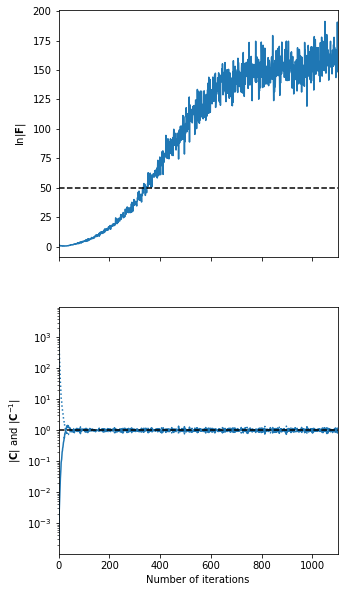

In [11]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 10))
ax[0].plot(detF)
#ax[0].plot([0, detF.shape[0]-1], [50, 50], linestyle="dashed", color="black")
ax[0].plot([0, counter], [50, 50], linestyle="dashed", color="black")
ax[0].set_xlim(0, detF.shape[0]-1)
ax[0].set_ylabel(r"$\ln|{\bf F}|$")
ax[1].plot(detC)
ax[1].plot(detinvC, linestyle="dotted", color="C0")
#ax[1].plot([0, detF.shape[0]-1], [1, 1], linestyle="dashed", color="black")
ax[1].plot([0, counter], [1, 1], linestyle="dashed", color="black")
ax[1].set_ylabel(r"$|{\bf C}|$ and $|{\bf C}^{-1}|$")
ax[1].set_yscale("log")
ax[1].set_xlabel("Number of iterations")

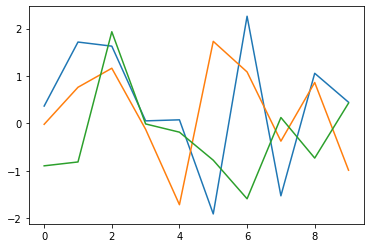

In [12]:
rng, *keys = jax.random.split(rng, num=4)
target_data = np.array([simulator(keys[i], θ_fid, shape=input_shape) for i in range(3)])
plt.plot(target_data.T);

In [13]:
rng, *keys = jax.random.split(rng, num=n_s+1)
F, C, invC, μ, dμ_dθ = get_Fisher(np.array(keys), θ_fid, best_w, shape=(10,), return_stats=True)
invF = np.linalg.inv(F)

In [22]:
target_summaries = get_estimate(target_data, θ_fid, invF, μ, invC, dμ_dθ, best_w)

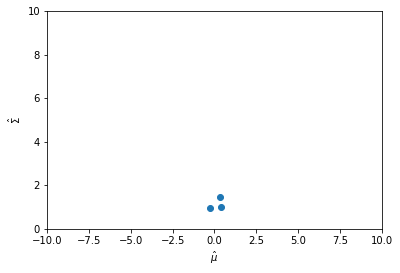

In [23]:
plt.scatter(*target_summaries.T)
plt.xlabel(r"$\hat{\mu}$")
plt.ylabel(r"$\hat{\Sigma}$")
plt.xlim([-10., 10.])
plt.ylim([0., 10.]);

In [42]:
abc_samples = int(1e7)
rng, key = jax.random.split(rng)
μ_abc = jax.random.uniform(key, shape=(abc_samples,), minval=-10.0, maxval=10.0)
rng, key = jax.random.split(rng)
Σ_abc = jax.random.uniform(key, shape=(abc_samples,), minval=0.0, maxval=10.0)
rng, key = jax.random.split(rng)
abc_summaries = get_estimate(simulator(key, (μ_abc, Σ_abc), shape=input_shape), θ_fid, invF, μ, invC, dμ_dθ, best_w)
abc_distances = np.einsum("ijk,kl,ijl->ij", np.expand_dims(target_summaries, 1) - np.expand_dims(abc_summaries, 0), F, np.expand_dims(target_summaries, 1) - np.expand_dims(abc_summaries, 0))

In [78]:
μ_range = np.linspace(-10., 10, 100)
Σ_range = np.linspace(0., 10., 100)
X, Y = np.meshgrid(μ_range, Σ_range)
GA = np.array([tfp.distributions.MultivariateNormalFullCovariance(loc=target_summaries[i], covariance_matrix=invF).prob(np.vstack([X.ravel(), Y.ravel()]).T).numpy().reshape((100, 100)) for i in range(3)])
GA_μ = np.sum(GA, 1)
GA_μ /= np.expand_dims(np.sum(GA_μ, -1), -1) * (μ_range[1] - μ_range[0])
GA_Σ = np.sum(GA, 2)
GA_Σ /= np.expand_dims(np.sum(GA_Σ, -1), -1) * (Σ_range[1] - Σ_range[0])

(0.0, 10.0)

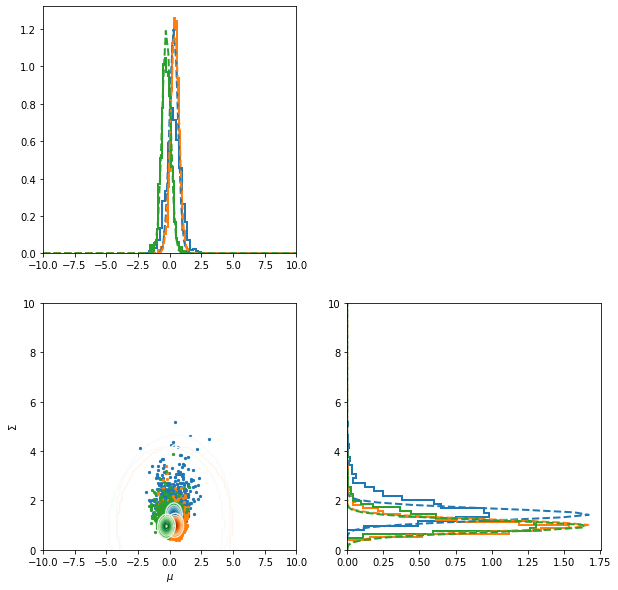

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(μ_range, GA_μ[0], linewidth=2, linestyle="dashed", color="C0")
ax[0, 0].plot(μ_range, GA_μ[1], linewidth=2, linestyle="dashed", color="C1")
ax[0, 0].plot(μ_range, GA_μ[2], linewidth=2, linestyle="dashed", color="C2")
ax[0, 0].hist(μ_abc[abc_distances[0] < 0.1], bins=25, histtype="step", density=True, linewidth=2, color="C0")
ax[0, 0].hist(μ_abc[abc_distances[1] < 0.1], bins=25, histtype="step", density=True, linewidth=2, color="C1")
ax[0, 0].hist(μ_abc[abc_distances[2] < 0.1], bins=25, histtype="step", density=True, linewidth=2, color="C2")
ax[0, 0].set_xlim([-10., 10.])
ax[0, 1].axis("off")
ax[1, 0].contour(μ_range, Σ_range, GA[0], cmap="Blues")
ax[1, 0].contour(μ_range, Σ_range, GA[1], cmap="Oranges")
ax[1, 0].contour(μ_range, Σ_range, GA[2], cmap="Greens")
ax[1, 0].scatter(μ_abc[abc_distances[0] < 0.1], Σ_abc[abc_distances[0] < 0.1], s=5, color="C0")
ax[1, 0].scatter(μ_abc[abc_distances[1] < 0.1], Σ_abc[abc_distances[1] < 0.1], s=5, color="C1")
ax[1, 0].scatter(μ_abc[abc_distances[2] < 0.1], Σ_abc[abc_distances[2] < 0.1], s=5, color="C2")
ax[1, 0].set_xlim([-10., 10.])
ax[1, 0].set_ylim([0., 10.])
ax[1, 0].set_xlabel(r"$\mu$")
ax[1, 0].set_ylabel(r"$\Sigma$")
ax[1, 1].plot(GA_Σ[0], Σ_range, linewidth=2, linestyle="dashed", color="C0")
ax[1, 1].plot(GA_Σ[1], Σ_range, linewidth=2, linestyle="dashed", color="C1")
ax[1, 1].plot(GA_Σ[2], Σ_range, linewidth=2, linestyle="dashed", color="C2")
ax[1, 1].hist(Σ_abc[abc_distances[0] < 0.1], bins=25, histtype="step", density=True, linewidth=2, orientation='horizontal', color="C0")
ax[1, 1].hist(Σ_abc[abc_distances[1] < 0.1], bins=25, histtype="step", density=True, linewidth=2, orientation='horizontal', color="C1")
ax[1, 1].hist(Σ_abc[abc_distances[2] < 0.1], bins=25, histtype="step", density=True, linewidth=2, orientation='horizontal', color="C2")
ax[1, 1].set_ylim([0., 10.])